In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import SelectFromModel,SequentialFeatureSelector

from sklearn.metrics import f1_score,accuracy_score,recall_score,precision_score,confusion_matrix,roc_auc_score

import warnings
warnings.simplefilter('ignore')

In [2]:
def model_basic(x_train, y_train, x_test, y_test):
    models = [
        LogisticRegression(),
        LinearDiscriminantAnalysis(),
        GaussianNB(),
        RandomForestClassifier(),
        XGBClassifier(),
        
    ]

    rdict = {'model': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1_score': [], 'auc_score': []}

    for clf in models:
        clf = clf.fit(x_train, y_train)
        pred = clf.predict(x_test)
        pred_prob_rf = clf.predict_proba(x_test)[:, 1].reshape(-1, 1)
        auc_score = roc_auc_score(y_test, pred_prob_rf)
        results = (
            round(accuracy_score(y_test, pred), 4),
            round(precision_score(y_test, pred), 4),
            round(recall_score(y_test, pred), 4),
            round(f1_score(y_test, pred), 4),
            round(auc_score, 4)
        )

        rdict['model'].append(clf)
        rdict['accuracy'].append(results[0])
        rdict['precision'].append(results[1])
        rdict['recall'].append(results[2])
        rdict['f1_score'].append(results[3])
        rdict['auc_score'].append(results[4])

        confusion = confusion_matrix(y_test, pred)
        print(confusion)

    rdf = pd.DataFrame(data=rdict)
    return rdf

In [10]:
train = pd.read_csv("./datasets/통계검증완료/코스닥_standard_train.csv",index_col=0)
train.rename(columns={'abs(영업현금흐름-당기순이익)/매출액':'CND'},inplace=True)
test =  pd.read_csv("./datasets/통계검증완료/코스닥_standard_test.csv",index_col=0)
test.rename(columns={'abs(영업현금흐름-당기순이익)/매출액':'CND'},inplace=True)


----

In [11]:
train.columns

Index(['회사명', '거래소코드', '회계년도', '산업군', '총자본순이익률', 'EBIT/총자산', '총자본정상영업이익률',
       '차입금의존도', '순운전자본비율', '현금흐름 대 매출액', 'EBITDA마진율', '현금흐름 대 자산', 'CND',
       '누적수익성비율', '타인자본회전률', 'WW지수', '당기전기영업손익', '금융비용부담률', '총자본회전률', '자본금회전률',
       'FINDEP', '총자본증가율', 'TMD', '매출액총이익률', '자기자본증가율', '매출액증가율', '합계_기말인원(명)',
       '정상영업이익증가율', '자기자본순이익률', '대주주지분율', 'target_1', 'target_2', 'target_3'],
      dtype='object')

In [12]:
col_int = ['총자본순이익률', 'EBIT/총자산', '총자본정상영업이익률',
       '차입금의존도', '순운전자본비율', '현금흐름 대 매출액', 'EBITDA마진율', '현금흐름 대 자산',
       'CND', '누적수익성비율', '타인자본회전률', 'WW지수', '당기전기영업손익',
       '금융비용부담률', '총자본회전률', '자본금회전률', 'FINDEP', '총자본증가율', 'TMD', '매출액총이익률',
       '자기자본증가율', '매출액증가율', '합계_기말인원(명)', '정상영업이익증가율', '자기자본순이익률', '대주주지분율']

---
#target1
---

In [13]:
x_train = train[col_int]
y_train = train[['target_1']]

x_test = test[col_int]
y_test = test[['target_1']]

In [14]:
y_test.value_counts()

target_1
0           2475
1             74
dtype: int64

In [15]:
#  선정된 피쳐를 저장하기 위한 데이터프레임 생성 
df_select = pd.DataFrame()
# 생성된 데이터프레임의 인덱스 지정
df_select.index = x_train.columns

---
# lasso - 임베디드기법
---

In [16]:
#  lasso
selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.01)).fit(x_train, y_train)
df_select["lasso_0.01"] = selector.get_support()

selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.05)).fit(x_train, y_train)
df_select["lasso_0.05"] = selector.get_support()

selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.1)).fit(x_train, y_train)
df_select["lasso_0.1"] = selector.get_support()


---
# stepwise - 래퍼기법
---

In [17]:
# logit foward
estimator = LogisticRegression(penalty='l1',solver='liblinear',C=0.05)
selector = SequentialFeatureSelector(estimator,direction='forward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select['logit_fwd'] = selector.get_support().tolist()
# logit backward
selector = SequentialFeatureSelector(estimator,direction='backward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select['logit_bwd'] = selector.get_support().tolist()

In [18]:
# lda foward
estimator = LinearDiscriminantAnalysis(solver='svd')
selector = SequentialFeatureSelector(estimator,direction='forward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select['lda_fwd'] = selector.get_support().tolist()
# lda backward
selector = SequentialFeatureSelector(estimator,direction='backward',cv=5,n_jobs=-1,)
selector.fit(x_train, y_train)
df_select['lda_bwd'] = selector.get_support().tolist()

---
## 비모수적 방법
---

In [19]:
# # RandomForest_foward
# estimator = RandomForestClassifier()
# selector = SequentialFeatureSelector(estimator,direction='forward',cv=2,n_jobs=-1)
# selector.fit(x_train, y_train)
# df_select['RFC_fwd'] = selector.get_support().tolist()
# # RandomForest _ backward
# selector = SequentialFeatureSelector(estimator,direction='backward',cv=2,n_jobs=-1)
# selector.fit(x_train, y_train)
# df_select['RFC_bwd'] = selector.get_support().tolist()

---
## 최종 select
---

In [20]:
for col in df_select.columns.to_list():
    df_select[col] = df_select[col].apply(lambda x : 1 if x==True else 0)
df_select['total'] = df_select.sum(axis=1)
df_select[df_select['total']>=5].index

Index(['총자본정상영업이익률', '현금흐름 대 자산', 'CND', '누적수익성비율', 'TMD', '자기자본순이익률',
       '대주주지분율'],
      dtype='object')

In [21]:
df_select[df_select['total']>=5]

,lasso_0.01,lasso_0.05,lasso_0.1,logit_fwd,logit_bwd,lda_fwd,lda_bwd,total
총자본정상영업이익률,1,1,1,0,1,1,1,6
현금흐름 대 자산,0,1,1,0,1,1,1,5
CND,1,1,1,1,1,1,1,7
누적수익성비율,1,1,1,1,1,1,1,7
TMD,1,1,1,1,1,1,1,7
자기자본순이익률,0,0,1,1,1,1,1,5
대주주지분율,0,1,1,0,1,1,1,5


In [22]:
최종_col =df_select[df_select['total']>=5].index.to_list()

# temp = ['EBIT/총자산', 'TMD', 'EBITDA마진율', '누적수익성비율', 'CND', '순운전자본비율','당기전기영업손익']
x_train_1 = x_train[최종_col]
x_test_1 = x_test[최종_col]

<AxesSubplot:title={'center':'Correlation of Features'}>

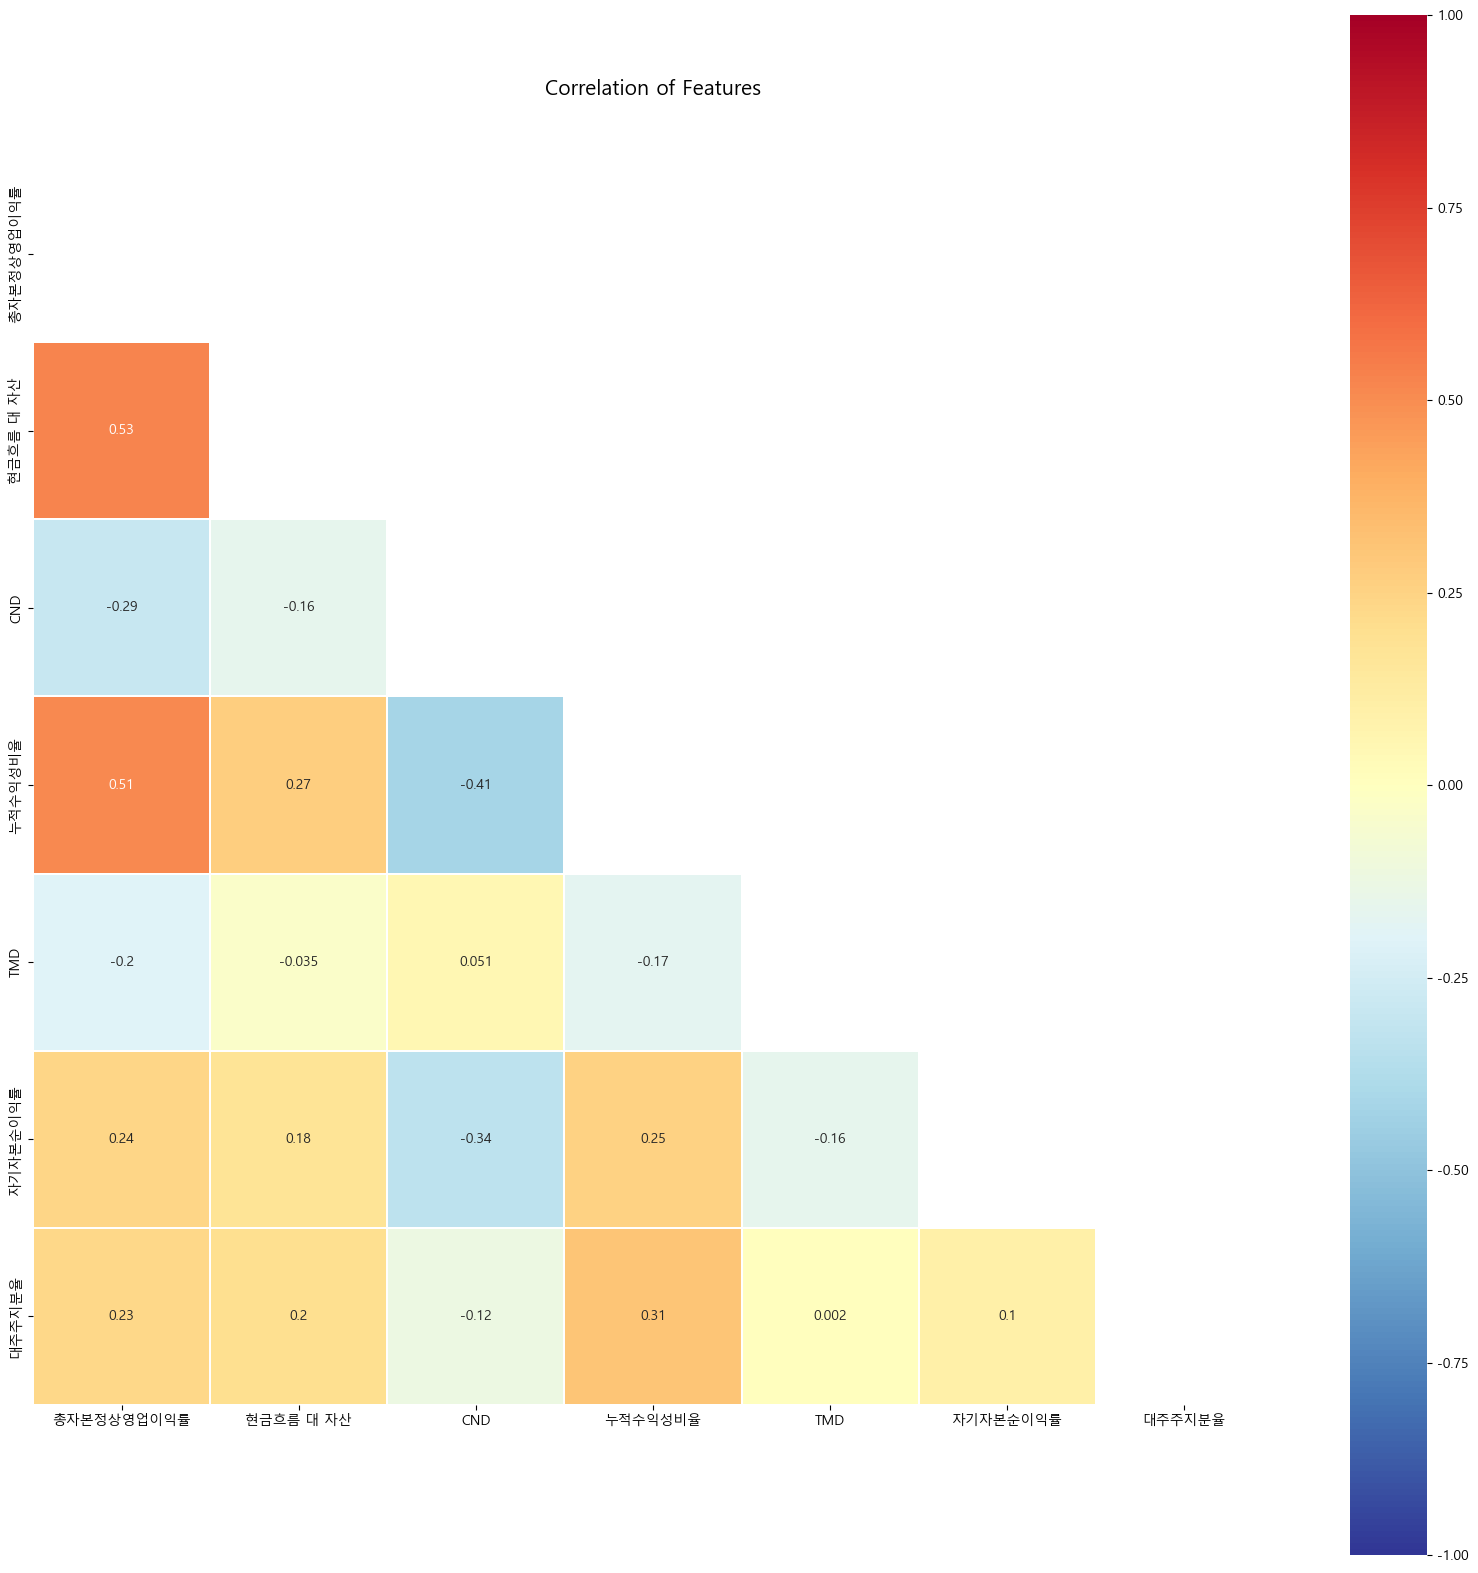

In [23]:
colormap = plt.cm.hot

corr = x_train_1.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(20, 20))
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family="Malgun Gothic")
plt.title("Correlation of Features", y=1.05, size=15)
sns.heatmap(corr,  linewidths=0.1, vmax=1.0, vmin=-1.0, square=True,mask=mask,
            cmap='RdYlBu_r', linecolor="white", annot=True, annot_kws={'size': 10})

In [24]:
model_basic(x_train_1,y_train,x_train_1,y_train)

[[4329   11]
 [  77   93]]
[[4335    5]
 [  88   82]]
[[4218  122]
 [  53  117]]
[[4340    0]
 [   0  170]]
[[4340    0]
 [   0  170]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9805,0.8942,0.5471,0.6788,0.9521
1,LinearDiscriminantAnalysis(),0.9794,0.9425,0.4824,0.6381,0.9480
2,GaussianNB(),0.9612,0.4895,0.6882,0.5721,0.9450
3,"(DecisionTreeClassifier(max_features='sqrt', r...",1.0000,1.0000,1.0000,1.0000,1.0000
4,"XGBClassifier(base_score=None, booster=None, c...",1.0000,1.0000,1.0000,1.0000,1.0000


In [25]:
model_basic(x_train_1,y_train,x_test_1,y_test)

[[2462   13]
 [  29   45]]
[[2464   11]
 [  29   45]]
[[2389   86]
 [  14   60]]
[[2465   10]
 [  17   57]]
[[2464   11]
 [  22   52]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9835,0.7759,0.6081,0.6818,0.9671
1,LinearDiscriminantAnalysis(),0.9843,0.8036,0.6081,0.6923,0.9702
2,GaussianNB(),0.9608,0.4110,0.8108,0.5455,0.9776
3,"(DecisionTreeClassifier(max_features='sqrt', r...",0.9894,0.8507,0.7703,0.8085,0.9867
4,"XGBClassifier(base_score=None, booster=None, c...",0.9871,0.8254,0.7027,0.7591,0.9787


-----
# target2

In [26]:
x_train = train[col_int]
y_train = train[['target_2']]

x_test = test[col_int]
y_test = test[['target_2']]

#  선정된 피쳐를 저장하기 위한 데이터프레임 생성 
df_select_2 = pd.DataFrame()
# 생성된 데이터프레임의 인덱스 지정
df_select_2.index = x_train.columns

In [28]:
#  lasso
selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.01)).fit(x_train, y_train)
df_select_2["lasso_0.01"] = selector.get_support()

selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.05)).fit(x_train, y_train)
df_select_2["lasso_0.05"] = selector.get_support()

selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.1)).fit(x_train, y_train)
df_select_2["lasso_0.1"] = selector.get_support()

# logit foward
estimator = LogisticRegression(penalty='l1',solver='liblinear',C=0.05)
selector = SequentialFeatureSelector(estimator,direction='forward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select_2['logit_fwd'] = selector.get_support().tolist()
# logit backward
selector = SequentialFeatureSelector(estimator,direction='backward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select_2['logit_bwd'] = selector.get_support().tolist()


# lda foward
estimator = LinearDiscriminantAnalysis(solver='svd')
selector = SequentialFeatureSelector(estimator,direction='forward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select_2['lda_fwd'] = selector.get_support().tolist()
# lda backward
selector = SequentialFeatureSelector(estimator,direction='backward',cv=5,n_jobs=-1,)
selector.fit(x_train, y_train)
df_select_2['lda_bwd'] = selector.get_support().tolist()

# # RandomForest_foward
# estimator = RandomForestClassifier()
# selector = SequentialFeatureSelector(estimator,direction='forward',cv=2,n_jobs=-1)
# selector.fit(x_train, y_train)
# df_select_2['RFC_fwd'] = selector.get_support().tolist()
# # RandomForest _ backward
# selector = SequentialFeatureSelector(estimator,direction='backward',cv=2,n_jobs=-1)
# selector.fit(x_train, y_train)
# df_select_2['RFC_bwd'] = selector.get_support().tolist()

In [29]:
for col in df_select_2.columns.to_list():
    df_select_2[col] = df_select_2[col].apply(lambda x : 1 if x==True else 0)
df_select_2['total'] = df_select_2.sum(axis=1)
df_select_2[df_select_2['total']>=5].index


Index(['총자본정상영업이익률', '현금흐름 대 매출액', '현금흐름 대 자산', 'CND', '누적수익성비율', '당기전기영업손익',
       '금융비용부담률', 'TMD', '매출액총이익률', '대주주지분율'],
      dtype='object')

In [30]:
df_select_2[df_select_2['total']>=5]

,lasso_0.01,lasso_0.05,lasso_0.1,logit_fwd,logit_bwd,lda_fwd,lda_bwd,total
총자본정상영업이익률,1,1,1,0,1,0,1,5
현금흐름 대 매출액,1,1,1,0,1,0,1,5
현금흐름 대 자산,0,1,1,1,0,1,1,5
CND,0,1,1,1,1,1,1,6
누적수익성비율,1,1,1,1,1,1,0,6
당기전기영업손익,0,1,1,1,1,1,0,5
금융비용부담률,1,1,1,0,1,1,0,5
TMD,1,1,1,1,1,1,1,7
매출액총이익률,0,1,1,1,1,1,0,5
대주주지분율,0,1,1,0,1,1,1,5


In [31]:
최종_col =df_select_2[df_select_2['total']>=5].index.to_list()

x_train_2 = x_train[최종_col]
x_test_2 = x_test[최종_col]

<AxesSubplot:title={'center':'Correlation of Features'}>

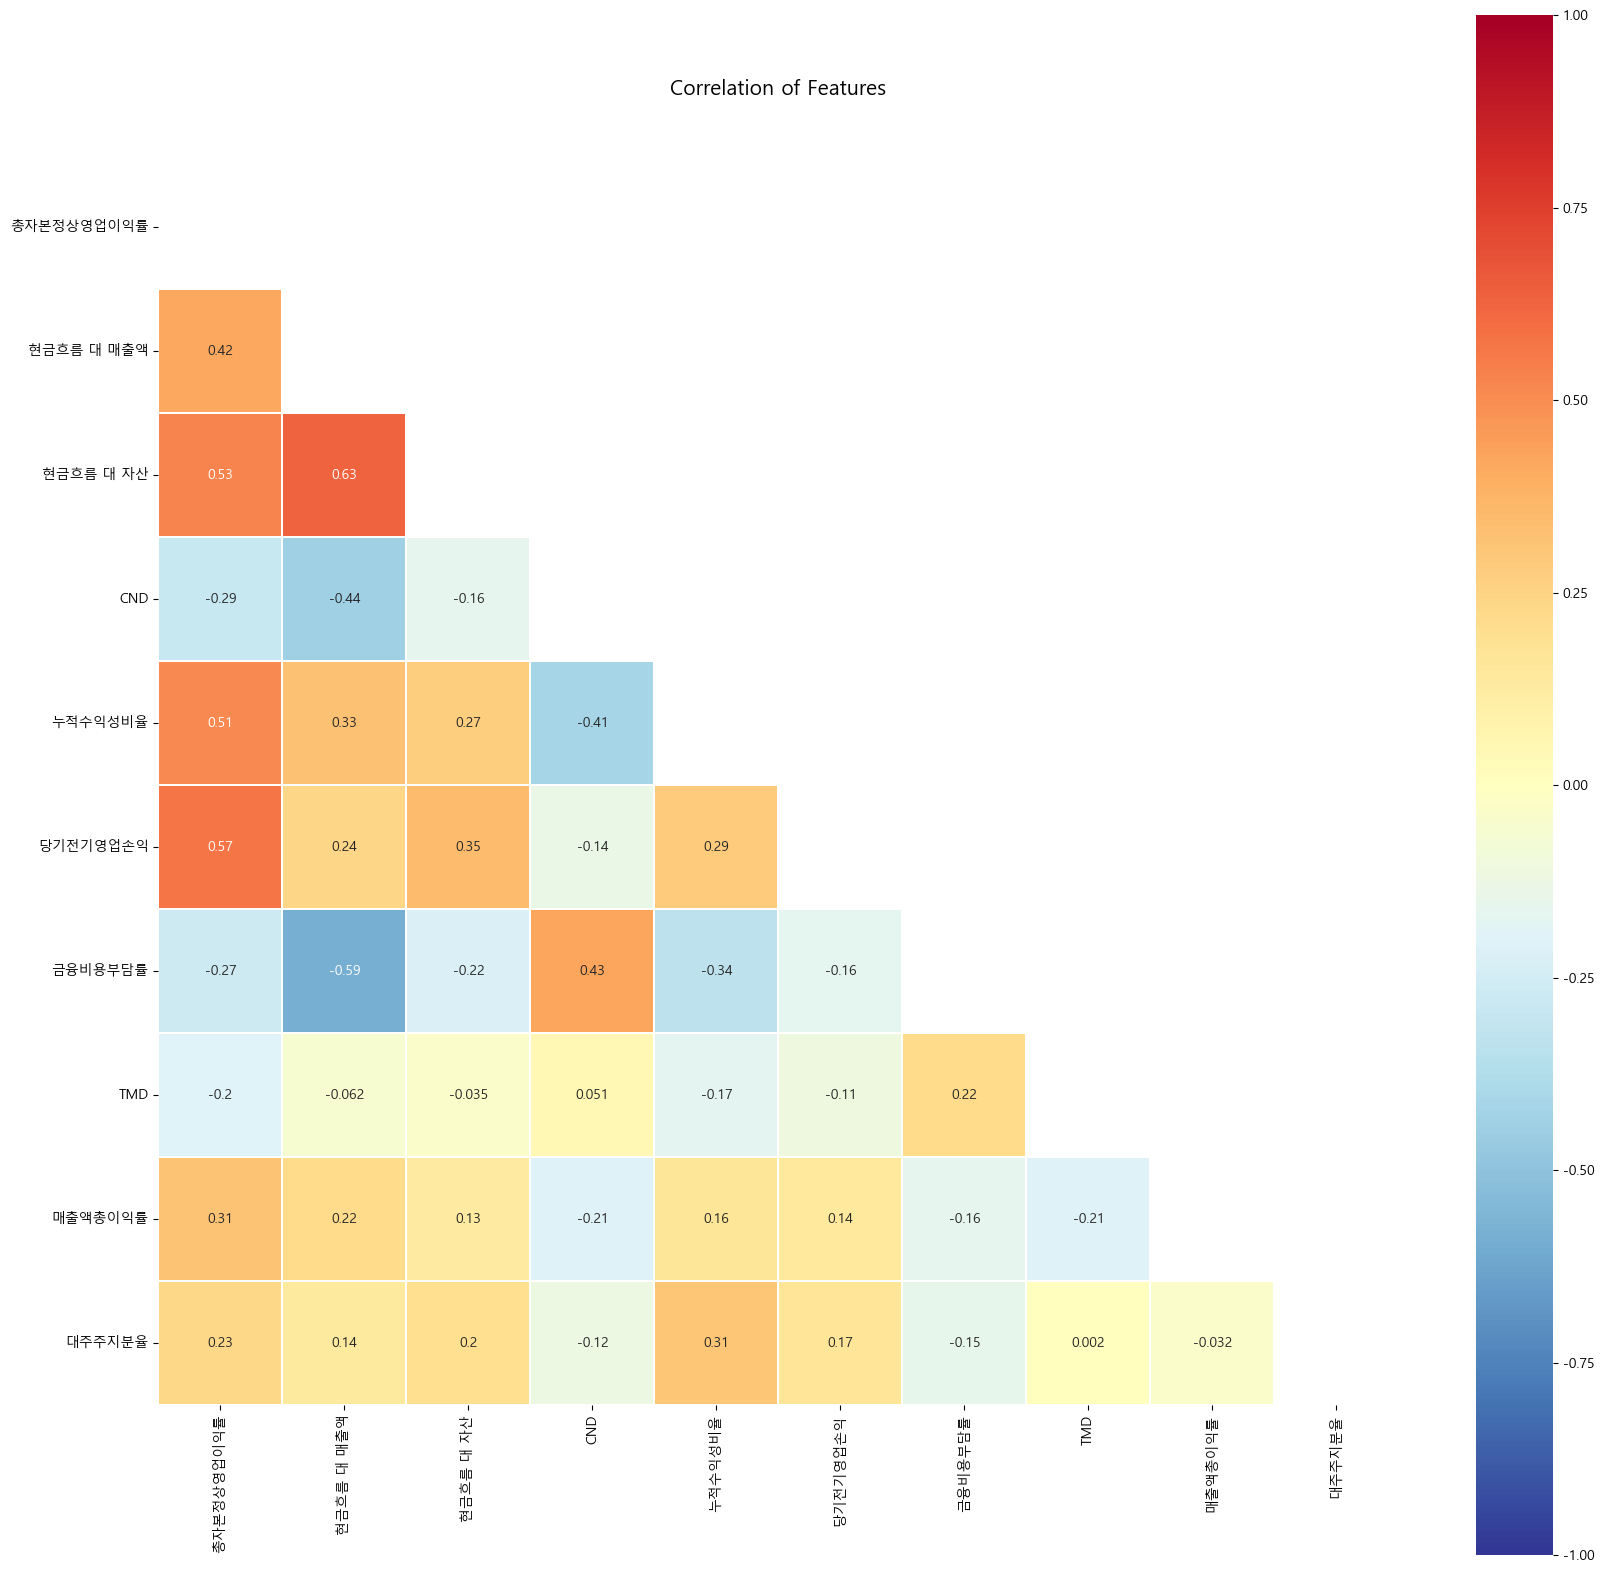

In [32]:
colormap = plt.cm.hot

corr = x_train_2.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(20, 20))
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family="Malgun Gothic")
plt.title("Correlation of Features", y=1.05, size=15)
sns.heatmap(corr,  linewidths=0.1, vmax=1.0, vmin=-1.0, square=True,mask=mask,
            cmap='RdYlBu_r', linecolor="white", annot=True, annot_kws={'size': 10})

In [33]:
model_basic(x_train_2,y_train,x_train_2,y_train)

[[4295   13]
 [ 106   96]]
[[4295   13]
 [ 116   86]]
[[4185  123]
 [  72  130]]
[[4308    0]
 [   0  202]]
[[4308    0]
 [   0  202]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9736,0.8807,0.4752,0.6174,0.9360
1,LinearDiscriminantAnalysis(),0.9714,0.8687,0.4257,0.5714,0.9324
2,GaussianNB(),0.9568,0.5138,0.6436,0.5714,0.9268
3,"(DecisionTreeClassifier(max_features='sqrt', r...",1.0000,1.0000,1.0000,1.0000,1.0000
4,"XGBClassifier(base_score=None, booster=None, c...",1.0000,1.0000,1.0000,1.0000,1.0000


In [34]:
model_basic(x_train_2,y_train,x_test_2,y_test)

[[2453   24]
 [  24   48]]
[[2455   22]
 [  20   52]]
[[2363  114]
 [   9   63]]
[[2466   11]
 [  13   59]]
[[2464   13]
 [  17   55]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9812,0.6667,0.6667,0.6667,0.9712
1,LinearDiscriminantAnalysis(),0.9835,0.7027,0.7222,0.7123,0.9733
2,GaussianNB(),0.9517,0.3559,0.8750,0.5060,0.9796
3,"(DecisionTreeClassifier(max_features='sqrt', r...",0.9906,0.8429,0.8194,0.8310,0.9929
4,"XGBClassifier(base_score=None, booster=None, c...",0.9882,0.8088,0.7639,0.7857,0.9876


----
# target3

In [35]:
x_train = train[col_int]
y_train = train[['target_3']]

x_test = test[col_int]
y_test = test[['target_3']]

c= train['target_3'].value_counts()
#  선정된 피쳐를 저장하기 위한 데이터프레임 생성 
df_select_3 = pd.DataFrame()
# 생성된 데이터프레임의 인덱스 지정
df_select_3.index = x_train.columns

In [36]:
#  lasso
selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.01)).fit(x_train, y_train)
df_select_3["lasso_0.01"] = selector.get_support()

selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.05)).fit(x_train, y_train)
df_select_3["lasso_0.05"] = selector.get_support()

selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.1)).fit(x_train, y_train)
df_select_3["lasso_0.1"] = selector.get_support()

# logit foward
estimator = LogisticRegression(penalty='l1',solver='liblinear',C=0.05)
selector = SequentialFeatureSelector(estimator,direction='forward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select_3['logit_fwd'] = selector.get_support().tolist()
# logit backward
selector = SequentialFeatureSelector(estimator,direction='backward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select_3['logit_bwd'] = selector.get_support().tolist()


# lda foward
estimator = LinearDiscriminantAnalysis(solver='svd')
selector = SequentialFeatureSelector(estimator,direction='forward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select_3['lda_fwd'] = selector.get_support().tolist()
# lda backward
selector = SequentialFeatureSelector(estimator,direction='backward',cv=5,n_jobs=-1,)
selector.fit(x_train, y_train)
df_select_3['lda_bwd'] = selector.get_support().tolist()

# # RandomForest_foward
# estimator = RandomForestClassifier()
# selector = SequentialFeatureSelector(estimator,direction='forward',cv=2,n_jobs=-1)
# selector.fit(x_train, y_train)
# df_select_3['RFC_fwd'] = selector.get_support().tolist()
# # RandomForest _ backward
# selector = SequentialFeatureSelector(estimator,direction='backward',cv=2,n_jobs=-1)
# selector.fit(x_train, y_train)
# df_select_3['RFC_bwd'] = selector.get_support().tolist()

In [37]:
for col in df_select_3.columns.to_list():
    df_select_3[col] = df_select_3[col].apply(lambda x : 1 if x==True else 0)
df_select_3['total'] = df_select_3.sum(axis=1)
df_select_3[df_select_3['total']>=5].index

Index(['현금흐름 대 매출액', '현금흐름 대 자산', 'CND', '누적수익성비율', 'WW지수', '금융비용부담률', 'TMD',
       '자기자본순이익률'],
      dtype='object')

In [38]:
df_select_3[(df_select_3['total']>=5)]

,lasso_0.01,lasso_0.05,lasso_0.1,logit_fwd,logit_bwd,lda_fwd,lda_bwd,total
현금흐름 대 매출액,1,1,1,1,1,1,0,6
현금흐름 대 자산,0,1,1,1,0,1,1,5
CND,1,1,1,1,1,1,1,7
누적수익성비율,1,1,1,1,1,1,1,7
WW지수,0,1,1,0,1,1,1,5
금융비용부담률,1,1,1,1,1,1,0,6
TMD,1,1,1,1,1,1,1,7
자기자본순이익률,0,0,1,1,1,1,1,5


In [39]:
최종_col =df_select_3[df_select_3['total']>=5].index.to_list()

x_train_3 = x_train[최종_col]
x_test_3 = x_test[최종_col]

<AxesSubplot:title={'center':'Correlation of Features'}>

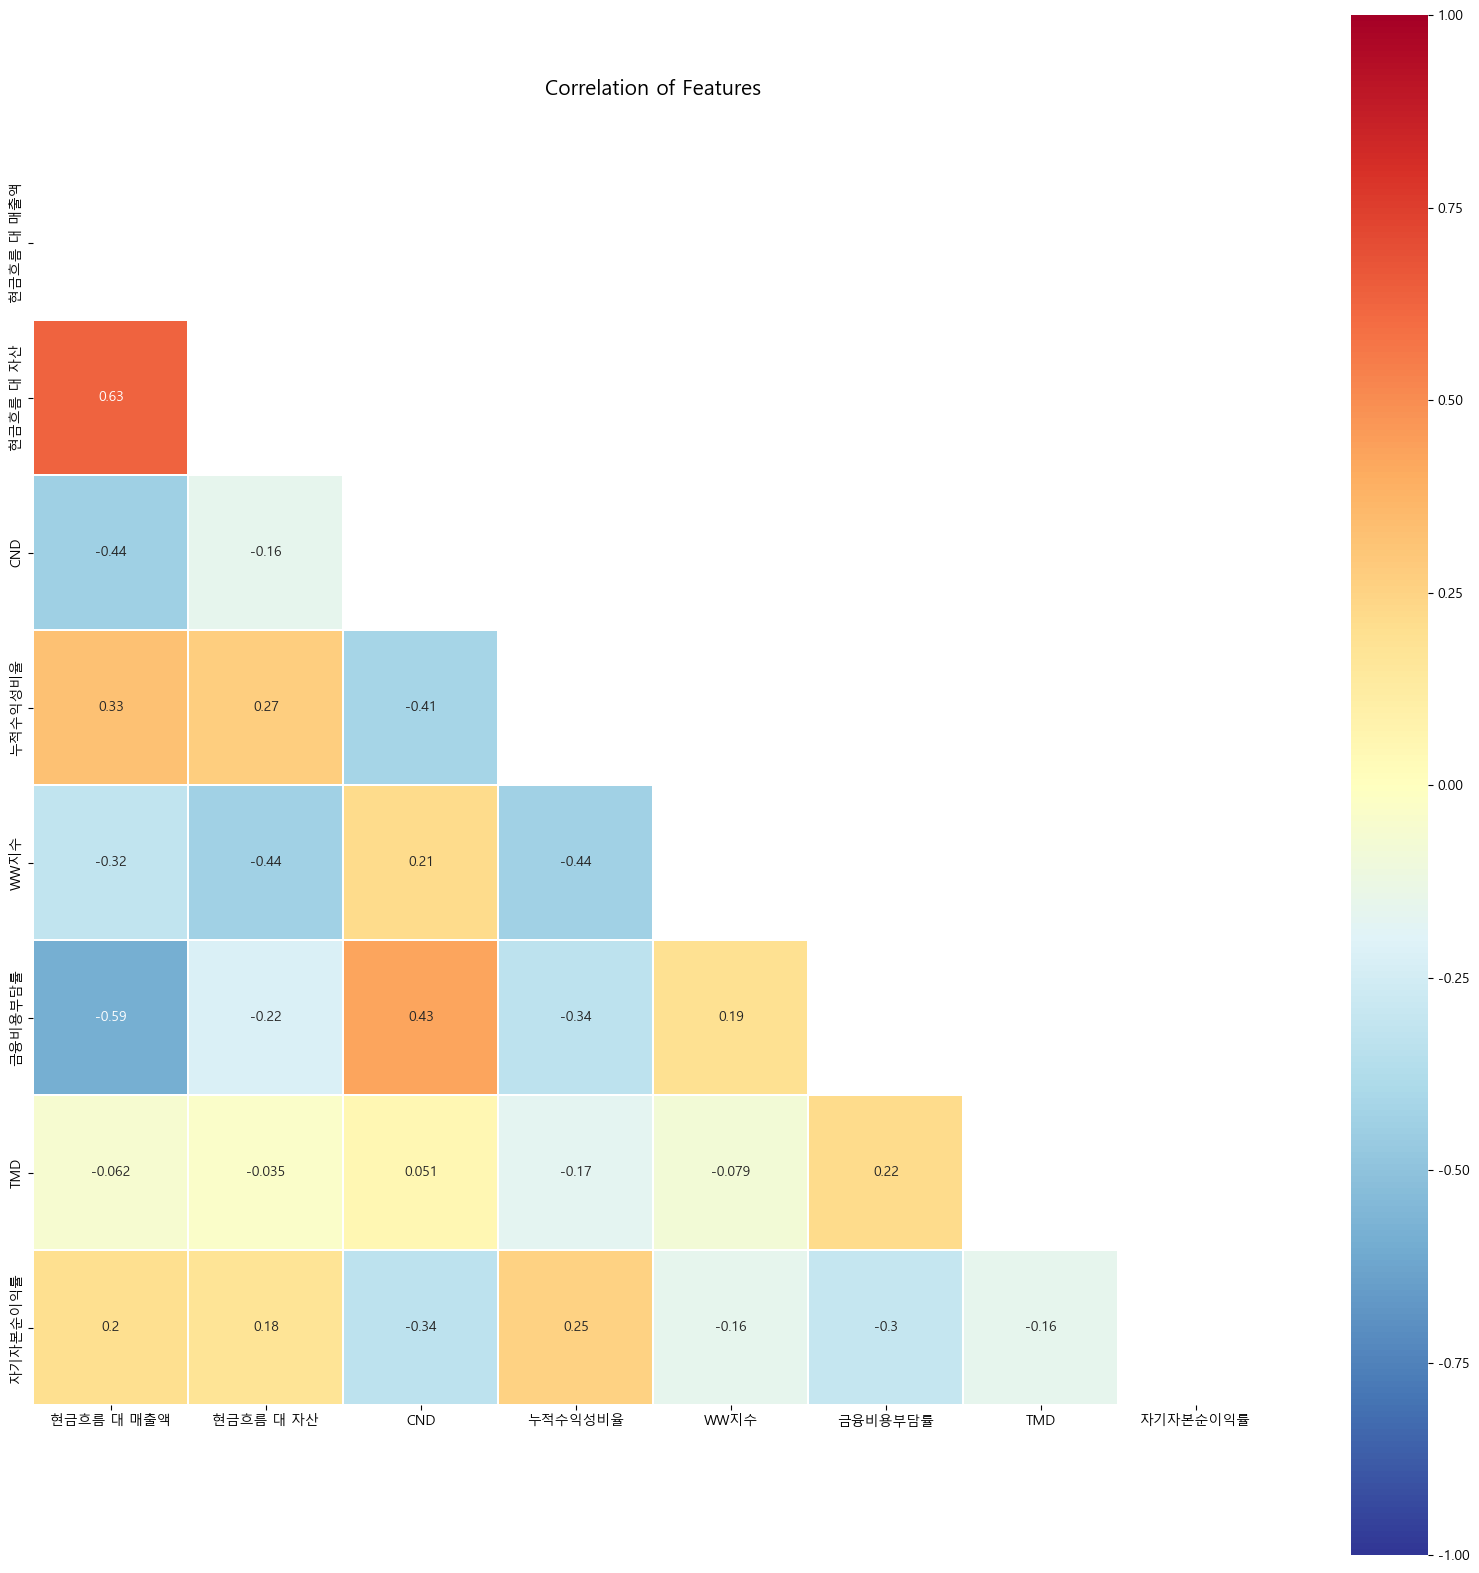

In [40]:
colormap = plt.cm.hot

corr = x_train_3.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(20, 20))
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family="Malgun Gothic")
plt.title("Correlation of Features", y=1.05, size=15)
sns.heatmap(corr,  linewidths=0.1, vmax=1.0, vmin=-1.0, square=True,mask=mask,
            cmap='RdYlBu_r', linecolor="white", annot=True, annot_kws={'size': 10})

In [41]:
model_basic(x_train_3,y_train,x_train_3,y_train)

[[4339    6]
 [  73   92]]
[[4338    7]
 [  87   78]]
[[4236  109]
 [  46  119]]
[[4345    0]
 [   0  165]]
[[4345    0]
 [   0  165]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9825,0.9388,0.5576,0.6996,0.9528
1,LinearDiscriminantAnalysis(),0.9792,0.9176,0.4727,0.6240,0.9468
2,GaussianNB(),0.9656,0.5219,0.7212,0.6056,0.9519
3,"(DecisionTreeClassifier(max_features='sqrt', r...",1.0000,1.0000,1.0000,1.0000,1.0000
4,"XGBClassifier(base_score=None, booster=None, c...",1.0000,1.0000,1.0000,1.0000,1.0000


In [42]:
model_basic(x_train_3,y_train,x_test_3,y_test)

[[2462   15]
 [  23   49]]
[[2465   12]
 [  24   48]]
[[2377  100]
 [  12   60]]
[[2464   13]
 [  22   50]]
[[2461   16]
 [  22   50]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9851,0.7656,0.6806,0.7206,0.9729
1,LinearDiscriminantAnalysis(),0.9859,0.8000,0.6667,0.7273,0.9731
2,GaussianNB(),0.9561,0.3750,0.8333,0.5172,0.9756
3,"(DecisionTreeClassifier(max_features='sqrt', r...",0.9863,0.7937,0.6944,0.7407,0.9618
4,"XGBClassifier(base_score=None, booster=None, c...",0.9851,0.7576,0.6944,0.7246,0.9729


-----------------------


In [90]:

# last_col = ['EBIT/총자산', '현금흐름 대 자산', 'WW지수', '누적수익성비율', 'abs(영업현금흐름-당기순이익)/매출액',
#        '금융비용부담률', 'TMD', '자기자본증가율', '자기자본순이익률', 'ROA변화율']
# x_train_3 = x_train[last_col]
# x_test_3 = x_test[last_col]

In [91]:
# colormap = plt.cm.hot

# corr = x_train_3.corr()
# mask = np.triu(np.ones_like(corr, dtype=np.bool))
# plt.figure(figsize=(20, 20))
# plt.rcParams['axes.unicode_minus'] = False
# plt.rc('font', family="Malgun Gothic")
# plt.title("Correlation of Features", y=1.05, size=15)
# sns.heatmap(corr,  linewidths=0.1, vmax=1.0, vmin=-1.0, square=True,mask=mask,
#             cmap='RdYlBu_r', linecolor="white", annot=True, annot_kws={'size': 10})

In [92]:
# model_basic(x_train_3,y_train,x_train_3,y_train)

In [93]:
# model_basic(x_train_3,y_train,x_test_3,y_test)